## Example notebook: Neural ODE with bifurcation parameter

This is an example notebook of how Neural ODEs can be applied to systems with a bifurcation parameter. We consider the classic Lorenz system:
\begin{equation}
\begin{split}
\dot{x} &= \sigma (y-x), \\
\dot{y} &= r x - y - x z, \\
\dot{z} &= x y - b z,
\end{split}
\end{equation}
with fixed parameters $\sigma = 10$ and $b = \tfrac{8}{3}$, and $r$ serving as the bifurcation parameter. We investigate the parameter range $1 \leq r \leq 30$, where the Lorenz system becomes chaotic near $r \approx 24.74$. 

In [1]:
# Import the necessary packages:
import torch
from torchdiffeq import odeint
import argparse
import os
import numpy as np
from dataframe import Dataframe
from neuralode import Neuralode
import random
import matplotlib.pyplot as plt
import scipy.integrate as sc_int
from math import exp
from scipy.integrate import solve_ivp
import wandb
import warnings

#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

We generate some synthetic training data based on the lorenz system for different value of the bifurcation parameter $r$ in the non-chaotic regime.

In [2]:
def lorenz(t, state, sigma, beta, r):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (r - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

r_list = [5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5]  # Example r values
initial_conditions = [[1.0, 1.0, 1.0],[-1.0, -1.0, 1.0]] # We use two initial conditions

t_eval = np.linspace(0, 5, 100)
x_data = []
r_data = []

for r in r_list:
    for init in initial_conditions:
        sol = solve_ivp(lorenz, [t_eval[0], t_eval[-1]], init, t_eval=t_eval, args=(10.0, 8/3, r))
        x_data.append(sol.y.T)
        r_data.append(r)

x_data = torch.tensor(np.stack(x_data, axis=1), dtype=torch.float32)  # Tensor of shape [100, 16, 3]
r_data = torch.tensor(r_data, dtype=torch.float32)                     # Tensor of shape [16]  
t_data = torch.tensor(t_eval, dtype=torch.float32)                   # Tensor of shape [100]

# Compute mean and std for x, y, z (over all time steps and trajectories)
xyz_mean = x_data.reshape(-1, 3).mean(dim=0)
xyz_std = x_data.reshape(-1, 3).std(dim=0)

# Compute mean and std for r
r_mean = r_data.mean()
r_std = r_data.std()

# Normalize
x_data_norm = (x_data - xyz_mean) / xyz_std
r_data_norm = (r_data - r_mean) / r_std

print("Generated synthetic data: x_data shape:", x_data.shape, "r_data shape:", r_data.shape)
print("Data was normalized using mean:", xyz_mean, "and std:", xyz_std, "for x, y, z and mean:", r_mean, "and std:", r_std, "for r.")


Generated synthetic data: x_data shape: torch.Size([100, 16, 3]) r_data shape: torch.Size([16])
Data was normalized using mean: tensor([ 0.0000,  0.0000, 11.4681]) and std: tensor([5.7091, 6.0478, 6.9959]) for x, y, z and mean: tensor(13.7500) and std: tensor(5.9161) for r.


We can train our bifurcation-parameter dependent neural ODE on our synthetic data. This may take some time (~15 minutes).

In [ ]:
EPOCHS = 2500


#Create dataframes from data
dataframe = Dataframe(t_data, x_data_norm, r_data_norm, variables=3, drivers=1,batchlength=20,batchsize=5)

#Create the model
model=Neuralode(3, 1, parameter_list=r_data_norm, hidden_layers=3,depth_of_layers=16)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS+1):

        #Get batch list for this epoch
        batch_list,a_list,batch_t=dataframe.get_batch_list()

        for i,batch in enumerate(batch_list):
            
            optimizer.zero_grad()

            #Set bifurcation parameters for batch
            model.parameter_list=a_list[i]
            
            #Do forward passes through network+odesolver
            pred_x = odeint(model, batch[0,:,:].float(), batch_t.float(), method='rk4', options={'step_size': 0.05})
            
            #Calculate losses
            loss = torch.mean(torch.abs(pred_x - batch))
        
            #Optimizer step
            loss.backward()
            optimizer.step()

        if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                model.parameter_list=dataframe.data_a
                pred_x = odeint(model, dataframe.data_x[0,:,:].float(), dataframe.data_t.float(), method='rk4', options={'step_size': 0.05})
                train_loss = torch.mean(torch.abs(pred_x - dataframe.data_x))
                print(f"Epoch: {epoch}  training loss {train_loss.item()}")  

        if epoch%100==0:
            # High-resolution time grid
            t_highres = torch.linspace(t_data[0], t_data[-1], 500).float()

            # Indices for the first initial condition for each r (0, 2, 4, ..., 14)
            indices = list(range(0, x_data_norm.shape[1], 2))

            # Stack initial states and r values for the first initial condition
            init_batch = torch.stack([x_data_norm[0, idx, :] for idx in indices], dim=0)  # [8, 3]
            r_batch = torch.stack([r_data_norm[idx] for idx in indices], dim=0)  # [8, 1]

            model.parameter_list = r_batch  # [8, 1]

            with torch.no_grad():
                pred_traj = odeint(model, init_batch, t_highres, method='rk4', options={'step_size': 0.05})  # [500, 8, 3]
                pred_traj = pred_traj.cpu().numpy()

            fig, axs = plt.subplots(1, len(indices), figsize=(3*len(indices), 3), subplot_kw={'projection': '3d'})
            if len(indices) == 1:
                axs = [axs]

            for i, ax in enumerate(axs):
                line_pred = ax.plot(pred_traj[:, i, 0], pred_traj[:, i, 1], pred_traj[:, i, 2], linewidth=3, label='Prediction')
                scatter_data = ax.scatter(
                    x_data_norm[:, indices[i], 0].cpu(),
                    x_data_norm[:, indices[i], 1].cpu(),
                    x_data_norm[:, indices[i], 2].cpu(),
                    color='black', s=4, alpha=0.6, label='Data'
                )
                ax.set_title(f"r = {r_list[i]}")
                ax.set_xlabel("x")
                ax.set_ylabel("y")
                ax.set_zlabel("z")
            fig.suptitle(f"Neural ODE Predictions for Different r Values (Epoch {epoch})")
            # Create a single legend for the whole figure
            handles = [axs[0].lines[0], axs[0].collections[0]]
            labels = [h.get_label() for h in handles]
            fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 1.05))
            img_dir = "training_images"
            os.makedirs(img_dir, exist_ok=True)
            img_path = os.path.join(img_dir, f"epoch_{epoch:04d}.png")
            plt.savefig(img_path)
            plt.close(fig)
                 
    

Epoch: 0  training loss 0.9424672722816467
Epoch: 20  training loss 0.6999261379241943
Epoch: 40  training loss 0.6986662745475769
Epoch: 60  training loss 0.7003088593482971
Epoch: 80  training loss 0.7232649922370911
Epoch: 100  training loss 0.7646666169166565
Epoch: 120  training loss 0.6215200424194336
Epoch: 140  training loss 0.6644383072853088
Epoch: 160  training loss 0.6096311807632446
Epoch: 180  training loss 0.6603628396987915
Epoch: 200  training loss 0.669041097164154
Epoch: 220  training loss 0.606078565120697
Epoch: 240  training loss 0.607106626033783
Epoch: 260  training loss 0.6094499230384827
Epoch: 280  training loss 0.6060389280319214
Epoch: 300  training loss 0.6097915172576904
Epoch: 320  training loss 0.6027509570121765
Epoch: 340  training loss 0.5970377326011658
Epoch: 360  training loss 0.5376660227775574
Epoch: 380  training loss 0.5278027653694153
Epoch: 400  training loss 0.5216926336288452
Epoch: 420  training loss 0.5550997257232666
Epoch: 440  trainin

We can visualise the training process.

C:\Users\tegel009\AppData\Local\Temp\ipykernel_10564\2096459962.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(img_dir, fname)))


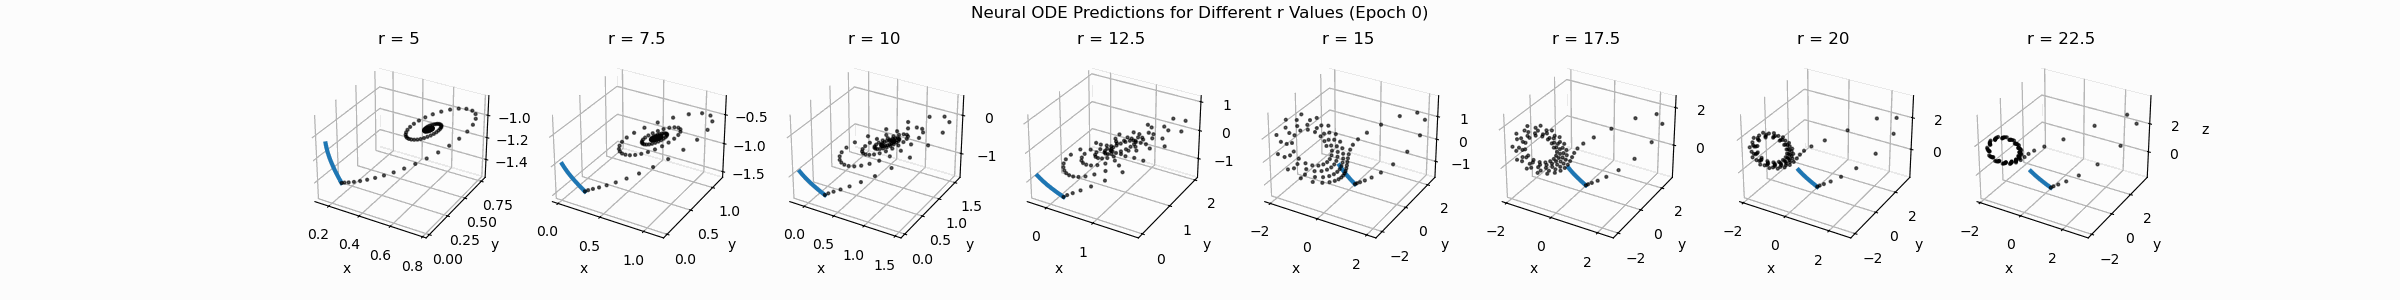

In [ ]:
import imageio
import os
from IPython.display import Image

img_dir = "training_images"
images = []
for fname in sorted(os.listdir(img_dir)):
    if fname.endswith(".png"):
        images.append(imageio.imread(os.path.join(img_dir, fname)))
imageio.mimsave("training_animation.gif", images, duration=0.5) 

Image(filename="training_animation.gif")

We can make an interactive plot to showcase our learned model and dynamics.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from scipy.integrate import solve_ivp

# Define r values and time grid
r_values = np.arange(5, 30.1, 2.5)
t_highres = np.linspace(float(t_data[0]), float(100), 5000)
init_cond = [1.0, 1.0, 1.0]  # unnormalized initial condition

# Precompute true system trajectories
true_traj = []
for r in r_values:
    sol = solve_ivp(
        lambda t, y: [
            10.0 * (y[1] - y[0]),
            y[0] * (r - y[2]) - y[1],
            y[0] * y[1] - (8/3) * y[2]
        ],
        [t_highres[0], t_highres[-1]],
        init_cond,
        t_eval=t_highres
    )
    # Normalize the true trajectory using xyz_mean and xyz_std
    traj_norm = (sol.y.T - xyz_mean.numpy()) / xyz_std.numpy()
    true_traj.append(traj_norm)
true_traj = np.stack(true_traj, axis=0)

init_batch = x_data_norm[0, 0, :].repeat(len(r_values), 1)  # [num_r, 3]
r_batch = torch.tensor([(r - r_mean.item()) / r_std.item() for r in r_values], dtype=torch.float32)  # [num_r, 1]
model.parameter_list = r_batch

with torch.no_grad():
    pred_x = odeint(model, init_batch, torch.tensor(t_highres, dtype=torch.float32), method='rk4', options={'step_size': 0.01})  # [500, num_r, 3]
    pred_x = pred_x.cpu().numpy()

def plot_both_trajectories(r_idx):
    r = r_values[r_idx]
    traj_pred = pred_x[:, r_idx, :]
    traj_true = true_traj[r_idx]
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': '3d'})

    # Predicted
    axs[0].plot(traj_pred[:, 0], traj_pred[:, 1], traj_pred[:, 2], color="#1c3066")
    axs[0].set_title(f"Model Prediction (r={r})")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")
    axs[0].set_zlabel("z")
    axs[0].set_xlim(-4, 4)
    axs[0].set_ylim(-4, 4)
    axs[0].set_zlim(-1, 4)

    # True
    axs[1].plot(traj_true[:, 0], traj_true[:, 1], traj_true[:, 2], color="#1b6942")
    axs[1].set_title(f"True System (r={r})")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("y")
    axs[1].set_zlabel("z")
    axs[1].set_xlim(-4, 4)
    axs[1].set_ylim(-4, 4)
    axs[1].set_zlim(-1, 4)

    plt.tight_layout()
    plt.show()
    plt.close(fig)

interact(plot_both_trajectories, r_idx=IntSlider(min=0, max=len(r_values)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='r_idx', max=10), Output()), _dom_classes=('widget-intera…

<function __main__.plot_both_trajectories(r_idx)>